# **Seq2Seq with Bahdanau Attention**

## **From Scratch Implementation in NumPy**

This notebook builds upon the standard Encoder-Decoder architecture by implementing **Bahdanau (Additive) Attention** [Bahdanau et al., 2014].

### **Why Attention?**
In a standard Encoder-Decoder, the Encoder must compress the entire source sentence into a single fixed-size vector (the "bottleneck"). This causes performance to degrade as sentences get longer.

**Attention** solves this by allowing the Decoder to "look back" at the entire sequence of Encoder hidden states. At every step of generation, the model calculates a **dynamic context vector** that focuses on the most relevant parts of the input.

### **Architecture Changes:**
1.  **Encoder:** Returns all hidden states $H = \{h_1, \dots, h_T\}$, not just the last one.
2.  **Attention Mechanism:** A small neural network that computes "Energy Scores" between the Decoder's previous state and every Encoder state.
3.  **Decoder:** Receives a concatenated input $[y_{t-1}; c_t]$ (Word Embedding + Context Vector).

---
*Notebook by*: Ahmad Raza [@ahmadrazacdx](https://github.com/ahmadrazacdx)<br>
*Date: 2025* <br>
*License: MIT*

In [1]:
import re
import random
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-v0_8')

In [2]:
data = open('../data/thirsty_crow_v2.txt', 'r').read().lower()
sentences = re.split(r'(?<=[.!?])\s+', data)
sentences = [s.strip() for s in sentences if len(s.strip()) > 0]
print(f"Found {len(sentences)} sentences.")
print(f"Example sentences: {sentences[:2]}")

Found 37 sentences.
Example sentences: ['the crow was thirsty .', 'a bird was very dry .']


In [3]:
#Build Vocab
words = []
for sent in sentences:
    word = re.findall(r"\w+|[.,!?'\";:]", sent)
    words.extend(word)

SOS_TOKEN = '<SOS>'  # Start of Sequence
EOS_TOKEN = '<EOS>'  # End of Sequence
UNK_TOKEN = '<UNK>'  # Unknown word

vocab = [SOS_TOKEN, EOS_TOKEN, UNK_TOKEN] + sorted(list(set(words)))
vocab_size = len(vocab)
word_to_ix = {w: i for i, w in enumerate(vocab)}
ix_to_word = {i: w for i, w in enumerate(vocab)}

print(f"Vocab Size: {vocab_size}")

Vocab Size: 82


In [4]:
#Create Training Pairs (Encoder(Input), Decoder(Target))  with Teacher Forcing
training_pairs = []

for i in range(len(sentences) - 1):
    src_text = sentences[i]
    src_words = re.findall(r"\w+|[.,!?'\";:]", src_text)
    src_indices = [word_to_ix[w] for w in src_words]

    trg_text = sentences[i+1]
    trg_words = re.findall(r"\w+|[.,!?'\";:]", trg_text)

    dec_input = [word_to_ix[SOS_TOKEN]] + [word_to_ix[w] for w in trg_words] # Decoder Input: <SOS> + sentence
    dec_target = [word_to_ix[w] for w in trg_words] + [word_to_ix[EOS_TOKEN]] # Decoder Target: sentence + <EOS>

    training_pairs.append({
        'src': src_indices,
        'dec_input': dec_input,
        'dec_target': dec_target
    })

print(f"\nExample Pair 0:")
print(f"Encoder Input (Indices): {training_pairs[0]['src']}")
print(f"Decoder Input (Indices): {training_pairs[0]['dec_input']}")
print(f"Decoder Target (Indices): {training_pairs[0]['dec_target']}")
print(f"Original Source: {sentences[0]}")
print(f"Original Target: {sentences[1]}")


Example Pair 0:
Encoder Input (Indices): [65, 17, 78, 69, 3]
Decoder Input (Indices): [0, 4, 10, 78, 77, 22, 3]
Decoder Target (Indices): [4, 10, 78, 77, 22, 3, 1]
Original Source: the crow was thirsty .
Original Target: a bird was very dry .


### __HYPER-PARAMETERS__

In [5]:
lr = 1e-3            # Learning rate
hidden_size = 100    # Size of hidden state (h)
embed_size = 100      # Size of embedding vector (e)
MAX_LEN = 25         # Max length for generation
clip_value = 5.0     # Gradient clipping threshold

### __MODEL PARAMETER INITIALIZATION__

New set of weights for the Attention Mechanism and resize the Decoder to accept the context vector. All weights initialized with **Xavier Initialization**.

**1. Shared Embeddings:**
- $\mathbf{W}_{emb} \in \mathbb{R}^{V \times E}$: Shared lookup table.

**2. Encoder Parameters:**
- $\mathbf{W}^{enc}_u, \mathbf{W}^{enc}_r, \mathbf{W}^{enc}_h \in \mathbb{R}^{H \times H+E}$: Weights for Update, Reset, and Candidate gates.
- $\mathbf{b}^{enc}_u, \mathbf{b}^{enc}_r, \mathbf{b}^{enc}_h \in \mathbb{R}^{H \times 1}$: Biases for the Encoder.

**3. Attention Parameters:**
This small network calculates the alignment score (energy) $e_{tj}$ between Decoder state $s_{t-1}$ and Encoder state $h_j$.
- $\mathbf{W}_a \in \mathbb{R}^{H \times H}$: Projects the Decoder state.
- $\mathbf{U}_a \in \mathbb{R}^{H \times H}$: Projects the Encoder state.
- $\mathbf{v}_a \in \mathbb{R}^{H \times 1}$: Projects the activation to a scalar score.

**4. The Bridge:**
- $\mathbf{W}_{bridge} \in \mathbb{R}^{H \times H}$: Learns how to translate the Encoder's final thought into the Decoder's starting thought.
- $\mathbf{b}_{bridge} \in \mathbb{R}^{H \times 1}$: Bias for the bridge.

**5. Decoder Parameters:**
The Decoder input is now the concatenation of the embedding ($E$) and the context vector ($H$)

- $\mathbf{W}^{dec}_u, \mathbf{W}^{dec}_r, \mathbf{W}^{dec}_h \in \mathbb{R}^{H \times (2H+E)}$: Weights for the Decoder GRU.
- $\mathbf{b}^{dec}_u, \mathbf{b}^{dec}_r, \mathbf{b}^{dec}_h \in \mathbb{R}^{H \times 1}$: Biases for the Decoder.
- $\mathbf{W}_y\in \mathbb{R}^{V \times H}$: Hidden-to-Output weight matrix (Vocabulary projection).
- $\mathbf{b}_y\in \mathbb{R}^{V \times 1}$: Output bias.

**Where:**  
- $V$ = vocabulary size  
- $E$ = embedding dimension (100)  
- $H$ = hidden size (100)

In [6]:
# 1. Shared Embeddings
emb_scale = np.sqrt(2.0 / (vocab_size + embed_size))
Wemb = np.random.randn(vocab_size, embed_size) * emb_scale

# 2. Encoder Parameters
enc_scale = np.sqrt(2.0 / ((hidden_size + embed_size) + hidden_size))
Wu_enc = np.random.randn(hidden_size, hidden_size + embed_size) * enc_scale
Wr_enc = np.random.randn(hidden_size, hidden_size + embed_size) * enc_scale
Wh_enc = np.random.randn(hidden_size, hidden_size + embed_size) * enc_scale
bu_enc = np.zeros((hidden_size, 1))
br_enc = np.zeros((hidden_size, 1))
bh_enc = np.zeros((hidden_size, 1))

# 3. Attention Parameters (Bahdanau)
attn_scale_proj = np.sqrt(2.0 / (hidden_size + hidden_size))
attn_scale_v = np.sqrt(2.0 / (hidden_size + 1))
Wa = np.random.randn(hidden_size, hidden_size) * attn_scale_proj
Ua = np.random.randn(hidden_size, hidden_size) * attn_scale_proj
va = np.random.randn(hidden_size, 1) * attn_scale_v

# 4. Bridge Parameters
bridge_scale = np.sqrt(2.0 / (hidden_size + hidden_size))
W_bridge = np.random.randn(hidden_size, hidden_size) * bridge_scale
b_bridge = np.zeros((hidden_size, 1))

# 5. Decoder Parameters
dec_input_dim = 2 * hidden_size + embed_size
dec_scale = np.sqrt(2.0 / (dec_input_dim + hidden_size))
Wu_dec = np.random.randn(hidden_size, dec_input_dim) * dec_scale
Wr_dec = np.random.randn(hidden_size, dec_input_dim) * dec_scale
Wh_dec = np.random.randn(hidden_size, dec_input_dim) * dec_scale

bu_dec = np.zeros((hidden_size, 1))
br_dec = np.zeros((hidden_size, 1))
bh_dec = np.zeros((hidden_size, 1))

# 6. Output Layer
out_scale = np.sqrt(2.0 / (hidden_size + vocab_size))
Wy = np.random.randn(vocab_size, hidden_size) * out_scale
by = np.zeros((vocab_size, 1))

In [7]:
print(f"""
Wemb: Word Embeddings        : {Wemb.shape}
=========================================
         ENCODER PARAMS
=========================================
Wu_enc: Update Gate Weights  : {Wu_enc.shape}
Wr_enc: Reset Gate Weights   : {Wr_enc.shape}
Wh_enc: CHS Weights          : {Wh_enc.shape}
bu_enc: Update Gate bias     : {bu_enc.shape}
br_enc: Reset Gate bias      : {br_enc.shape}
bh_enc: CHS bias             : {bh_enc.shape}
=========================================
         ATTENTION PARAMS
=========================================
Wa: Decoder State Weights    : {Wa.shape}
Ua: Encoder State Weights    : {Ua.shape}
va: Energy Score Weights     : {va.shape}
=========================================
         BRIDGE PARAMS
=========================================
W_bridge: Bridge Weights     : {W_bridge.shape}
b_bridge: Bridge bias        : {b_bridge.shape}
=========================================
         DECODER PARAMS (Resized)
=========================================
Wu_dec: Update Gate Weights  : {Wu_dec.shape}
Wr_dec: Reset Gate Weights   : {Wr_dec.shape}
Wh_dec: CHS Weights          : {Wh_dec.shape}
bu_dec: Update Gate bias     : {bu_dec.shape}
br_dec: Reset Gate bias      : {br_dec.shape}
bh_dec: CHS bias             : {bh_dec.shape}
=========================================
Wy: Prediction Weights       : {Wy.shape}
by: Prediction bias          : {by.shape}
""")


Wemb: Word Embeddings        : (82, 100)
         ENCODER PARAMS
Wu_enc: Update Gate Weights  : (100, 200)
Wr_enc: Reset Gate Weights   : (100, 200)
Wh_enc: CHS Weights          : (100, 200)
bu_enc: Update Gate bias     : (100, 1)
br_enc: Reset Gate bias      : (100, 1)
bh_enc: CHS bias             : (100, 1)
         ATTENTION PARAMS
Wa: Decoder State Weights    : (100, 100)
Ua: Encoder State Weights    : (100, 100)
va: Energy Score Weights     : (100, 1)
         BRIDGE PARAMS
W_bridge: Bridge Weights     : (100, 100)
b_bridge: Bridge bias        : (100, 1)
         DECODER PARAMS (Resized)
Wu_dec: Update Gate Weights  : (100, 300)
Wr_dec: Reset Gate Weights   : (100, 300)
Wh_dec: CHS Weights          : (100, 300)
bu_dec: Update Gate bias     : (100, 1)
br_dec: Reset Gate bias      : (100, 1)
bh_dec: CHS bias             : (100, 1)
Wy: Prediction Weights       : (82, 100)
by: Prediction bias          : (82, 1)



### __ADAM OPTIMIZER INITIALIZATION__

In [8]:
# Adam hyperparameters
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8

# 1. Embeddings
mWemb = np.zeros_like(Wemb); vWemb = np.zeros_like(Wemb)

# 2. Encoder
mWu_enc = np.zeros_like(Wu_enc); vWu_enc = np.zeros_like(Wu_enc)
mWr_enc = np.zeros_like(Wr_enc); vWr_enc = np.zeros_like(Wr_enc)
mWh_enc = np.zeros_like(Wh_enc); vWh_enc = np.zeros_like(Wh_enc)
mbu_enc = np.zeros_like(bu_enc); vbu_enc = np.zeros_like(bu_enc)
mbr_enc = np.zeros_like(br_enc); vbr_enc = np.zeros_like(br_enc)
mbh_enc = np.zeros_like(bh_enc); vbh_enc = np.zeros_like(bh_enc)

# 3. Attention
mWa = np.zeros_like(Wa); vWa = np.zeros_like(Wa)
mUa = np.zeros_like(Ua); vUa = np.zeros_like(Ua)
mva = np.zeros_like(va); vva = np.zeros_like(va)

# 4. Bridge
mW_bridge = np.zeros_like(W_bridge); vW_bridge = np.zeros_like(W_bridge)
mb_bridge = np.zeros_like(b_bridge); vb_bridge = np.zeros_like(b_bridge)

# 5. Decoder
mWu_dec = np.zeros_like(Wu_dec); vWu_dec = np.zeros_like(Wu_dec)
mWr_dec = np.zeros_like(Wr_dec); vWr_dec = np.zeros_like(Wr_dec)
mWh_dec = np.zeros_like(Wh_dec); vWh_dec = np.zeros_like(Wh_dec)
mbu_dec = np.zeros_like(bu_dec); vbu_dec = np.zeros_like(bu_dec)
mbr_dec = np.zeros_like(br_dec); vbr_dec = np.zeros_like(br_dec)
mbh_dec = np.zeros_like(bh_dec); vbh_dec = np.zeros_like(bh_dec)

# 6. Output Layer
mWy = np.zeros_like(Wy); vWy = np.zeros_like(Wy)
mby = np.zeros_like(by); vby = np.zeros_like(by)

# Timestep counter
t_adam = 0

In [9]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))
def softmax(z):
    exp_z = np.exp(z - np.max(z))
    return exp_z / np.sum(exp_z, axis=0, keepdims=True)

### __ATTENTION & GRU LOGIC__

#### **A. The Attention Mechanism (Additive)**
At decoding step $t$, we calculate how much focus to put on each encoder state $h_j$ based on the previous decoder state $S_{t-1}$.

**1. Energy Scores ($e_{tj}$):**
$$e_{tj} = \mathbf{v}_a^T \tanh(\mathbf{W}_a s_{t-1} + \mathbf{U}_a h_j)$$
*Note: This uses broadcasting to add the projected decoder vector to every projected encoder column.*

**2. Attention Weights ($\alpha_{tj}$):**
We apply Softmax over the time dimension ($j=1 \dots T_{enc}$) to get probabilities.
$$\alpha_{tj} = \frac{\exp(e_{tj})}{\sum_{k=1}^{T} \exp(e_{tk})}$$

**3. Context Vector ($c_t$):**
The weighted sum of encoder states.
$$c_t = \sum_{j=1}^{T} \alpha_{tj} h_j$$


#### **B. Decoder GRU Step**
The Decoder takes the context vector $c_t$ alongside the word embedding $y_{t-1}$.

**Input:** $\mathbf{x}^{dec}_t = [y_{t-1}; c_t]$ (Concatenation)

**Update Gate:**
$$\mathbf{z}_u = \mathbf{W}^{dec}_u [s_{t-1}; \mathbf{x}^{dec}_t] + \mathbf{b}^{dec}_u$$

*(Other gates follow the standard GRU pattern using this concatenated input)*

In [10]:
# ENCODER
def encoder_step(h_prev, word_idx):
    """
    Single GRU step for the Encoder. Uses _enc weights and DOES NOT compute output yt.
    """
    et = Wemb[word_idx].reshape(-1, 1)  # (E, 1)
    zt = np.concatenate((h_prev, et), axis=0) # (H+E, 1)
    zu = np.dot(Wu_enc, zt) + bu_enc #(H,H+E)@(H+E,1)->(H,1)+(H,1)=(H,1)
    ut = sigmoid(zu) # (H,1)
    zr = np.dot(Wr_enc, zt) + br_enc ##(H,H+E)@(H+E,1)->(H,1)+(H,1)=(H,1)
    rt = sigmoid(zr) # (H,1)
    Wh_h = Wh_enc[:, :hidden_size] # (H,H)
    Wh_x = Wh_enc[:, hidden_size:] # (H,E)
    zcht = np.dot(Wh_x, et) + rt * np.dot(Wh_h, h_prev) + bh_enc #(H,1)
    cht = np.tanh(zcht) # (H,1)
    ht = (1 - ut) * cht + ut * h_prev # (H,1)*(H,1) + (H,1)*(H,1)=(H,1)
    return et, ut, rt, cht, ht

# ATTENTION MECHANISM
def calculate_attention(s_prev, enc_matrix):
    """
    Bahdanau Attention (Additive).

    Inputs:
        - s_prev: Decoder's previous hidden state (H, 1)
        - enc_matrix: All Encoder hidden states stacked (H, Seq_Len(T))

    Returns:
        - context_vector: Weighted sum of encoder states (H, 1)
        - alphas: Attention weights (1, Seq_Len) - for visualization
        - energy: Raw scores (needed for backprop)
    """
    # 1. Calculate Energy Scores
    decoder_proj = np.dot(Wa, s_prev) #(H,H)@(H,1)=(H,1)
    encoder_proj = np.dot(Ua, enc_matrix) #(H,H)@(H,seq_len)=(H,seq_len(T))
    activation = np.tanh(decoder_proj + encoder_proj) #(H,1)+(H,seq_len)=(H,seq_len) -Broadcasting
    energy = np.dot(va.T, activation) # (1,H)@(H,seq_len)=(1,seq_len)

    # 2. Calculate Attention Weights (Softmax)
    exp_energy = np.exp(energy - np.max(energy))
    alphas = exp_energy / np.sum(exp_energy, axis=1, keepdims=True) # (1, seq_Len)

    # 3. Calculate Context Vector
    context_vector = np.dot(enc_matrix, alphas.T) # (H,seq_len)@(seq_len,1)=(H,1)
    return context_vector, alphas, energy


# DECODER
def decoder_step(h_prev, word_idx, context_vector):
    """
    Single GRU step for the Decoder with Attention.

    Changes:
    - Input is now [Embedding; Context Vector] instead of just Embedding.
    """
    et = Wemb[word_idx].reshape(-1, 1) # (E, 1)
    gru_input = np.concatenate((et, context_vector), axis=0) #(E,1)+(H,1)=(E+H,1)
    zt = np.concatenate((h_prev, gru_input), axis=0) #(H,1)+(E+H,1)=(2H+E,1)

    # GRU Logic
    zu = np.dot(Wu_dec, zt) + bu_dec # (H,2H+E)@(2H+E,1)=(H,1)+(H,1)=(H,1)
    ut = sigmoid(zu) #(H,1)

    zr = np.dot(Wr_dec, zt) + br_dec # (H,2H+E)@(2H+E,1)=(H,1)+(H,1)=(H,1)
    rt = sigmoid(zr) #(H,1)

    # Split Wh for candidate calculation
    Wh_h = Wh_dec[:, :hidden_size]      # (H, H)
    Wh_x = Wh_dec[:, hidden_size:]      # (H, E+H)
    zcht = np.dot(Wh_x, gru_input) + rt * np.dot(Wh_h, h_prev) + bh_dec
    # (H,E+H)@(E+H,1)=(H,1)+(H,1)*(H,H)@(H,1):(H,1)=(H,1)
    cht = np.tanh(zcht) #(H,1)

    ht = (1 - ut) * cht + ut * h_prev #(H,1)
    yt = np.dot(Wy, ht) + by #(V,1)
    return et, ut, rt, cht, ht, yt

### __UNDERSTANDING THE GRU CELLS WITH ATTENTION__

The attention mechanism changes how the Decoder processes information compared to the standard Encoder-Decoder.

**1. Encoder GRU (The Reader)**
- **Inputs:** Current word embedding $\mathbf{e}_t$ and Previous hidden state $\mathbf{h}_{t-1}$.
- **Action:** Processes the source sentence and produces a sequence of hidden states $\{h_1, h_2, \dots, h_T\}$.
- **Outputs:**
  1. Hidden state at each timestep $\mathbf{h}_t$ (all states are kept, not just the final one).
  2. Cache values $(\mathbf{e}_t, \mathbf{u}_t, \mathbf{r}_t, \tilde{\mathbf{h}}_t)$ for backprop.
- **Note:** Does **not** produce output logits ($\mathbf{y}_t$).

**2. Attention Mechanism (The Focus)**
- **Purpose:** At each decoder step, dynamically compute which encoder states are most relevant.
- **Process:**
  1. Compare decoder state $s_{t-1}$ with all encoder states
  2. Compute attention weights $\alpha_{tj}$ (how much to focus on each encoder position)
  3. Create context vector $c_t$ as weighted sum of encoder states
- **Key Benefit:** No fixed bottleneck—decoder can "look back" at the entire source sentence.

**3. Decoder GRU (The Writer with Context Awareness)**
- **Inputs:**
  1. Current word embedding $\mathbf{e}_t$ (from Teacher Forcing or previous prediction)
  2. **Context vector $\mathbf{c}_t$** from attention mechanism
  3. Previous decoder state $s_{t-1}$
- **Key Change:** The GRU input is now $[\mathbf{e}_t; \mathbf{c}_t]$ instead of just $\mathbf{e}_t$
- **Action:** Updates memory using context-aware information and predicts next word.
- **Outputs:**
  1. New hidden state $s_t$.
  2. **Logits $\mathbf{y}_t$** (Projected to vocabulary size).
  3. Cache values $(\mathbf{e}_t, \mathbf{u}_t, \mathbf{r}_t, \tilde{\mathbf{h}}_t)$.

**Flow Summary:**
```
Source → Encoder → [h₁, h₂, ..., hₜ] → Attention → Context → Decoder → Prediction
                          ↑_______________|
```
The decoder's attention weights at each step determine which parts of the source sentence are most important for generating the current target word.

### __FORWARD PASS__


In [11]:
def forward(src_inputs, dec_inputs, dec_targets):
    """
    Forward pass with Bahdanau Attention.

    Returns:
        - loss: Scalar loss
        - caches: grouping of all intermediate values for backprop
    """
    # ENCODER PHASE
    enc_et, enc_ut, enc_rt, enc_cht, enc_ht = {}, {}, {}, {}, {}
    h_enc_init = np.zeros((hidden_size, 1))
    enc_ht[-1] = h_enc_init
    for t in range(len(src_inputs)):
        word_idx = src_inputs[t]
        enc_et[t], enc_ut[t], enc_rt[t], enc_cht[t], enc_ht[t] = encoder_step(enc_ht[t-1], word_idx)

    # Stack all hidden states columns side-by-side for matrix multiplication
    # enc_ht[t] is (H, 1), so concatenating on axis 1 gives (H, seq_len(T))
    enc_list = [enc_ht[t] for t in range(len(src_inputs))]
    enc_matrix = np.concatenate(enc_list, axis=1)

    # BRIDGE
    h_enc_final = enc_ht[len(src_inputs) - 1] # (H,1)
    bridge_z = np.dot(W_bridge, h_enc_final) + b_bridge # (H,1)
    h_dec_init = np.tanh(bridge_z) # (H,1)
    bridge_cache = (h_enc_final, bridge_z, h_dec_init) # (H,1)

    # DECODER PHASE
    dec_et, dec_ut, dec_rt, dec_cht, dec_ht, dec_yt = {}, {}, {}, {}, {}, {}
    dec_probt = {}
    # ATTENTION CACHES
    attn_contexts = {}  # Store c_t
    attn_alphas = {}    # Store alpha_t (for visualization)
    attn_energies = {}  # Store e_t

    dec_ht[-1] = np.copy(h_dec_init)
    loss = 0

    for t in range(len(dec_inputs)):
        word_idx = dec_inputs[t]
        target_idx = dec_targets[t]
        context, alpha, energy = calculate_attention(dec_ht[t-1], enc_matrix)
        attn_contexts[t] = context
        attn_alphas[t] = alpha
        attn_energies[t] = energy
        # Decoder Step
        dec_et[t], dec_ut[t], dec_rt[t], dec_cht[t], dec_ht[t], dec_yt[t] = decoder_step(dec_ht[t-1], word_idx, context)
        dec_probt[t] = softmax(dec_yt[t])
        loss += -np.log(dec_probt[t][target_idx, 0] + epsilon)

    enc_cache = (enc_et, enc_ut, enc_rt, enc_cht, enc_ht, enc_matrix)
    dec_cache = (dec_et, dec_ut, dec_rt, dec_cht, dec_ht, dec_yt, dec_probt)
    attn_cache = (attn_contexts, attn_alphas, attn_energies)

    return loss, enc_cache, bridge_cache, dec_cache, attn_cache

## __BACKWARD PASS (BPTT) WITH ATTENTION__

**Backpropagation Through Time for Encoder-Decoder with Bahdanau Attention**

### **DECODER BACKWARD PASS**

#### **Step 1: Output Layer Gradient (Softmax + Cross-Entropy)**

$$\frac{\partial \mathcal{L}_t}{\partial \mathbf{y}_t} = \mathbf{p}_t - \mathbf{1}_{y^*_t}$$

**Output layer weight gradients:**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{W}_y} = \sum_{t=0}^{T_{dec}-1} \frac{\partial \mathcal{L}_t}{\partial \mathbf{y}_t} (\mathbf{s}_t)^T$$

$$\frac{\partial \mathcal{L}}{\partial \mathbf{b}_y} = \sum_{t=0}^{T_{dec}-1} \frac{\partial \mathcal{L}_t}{\partial \mathbf{y}_t}$$

#### **Step 2: Decoder Hidden State Gradient**

$$\frac{\partial \mathcal{L}}{\partial \mathbf{s}_t} = \mathbf{W}_y^T \frac{\partial \mathcal{L}_t}{\partial \mathbf{y}_t} + \frac{\partial \mathcal{L}}{\partial \mathbf{s}_{t+1}}$$

The gradient flows from:
- Current timestep's output loss (first term)
- Future timestep's hidden state (second term)
- **Attention mechanism** (additional gradient path)

### **ATTENTION MECHANISM BACKWARD PASS**

#### **Step 3: Gradient w.r.t. Context Vector**

From the decoder GRU, we receive $\frac{\partial \mathcal{L}}{\partial \mathbf{c}_t}$ (gradient w.r.t. context).

**Context Calculation (Forward):**
$$\mathbf{c}_t = \sum_{j=1}^{T_{enc}} \alpha_{tj} \mathbf{h}_j = \mathbf{H} \boldsymbol{\alpha}_t^T$$

Where $\mathbf{H} = [\mathbf{h}_1, \mathbf{h}_2, \dots, \mathbf{h}_{T_{enc}}] \in \mathbb{R}^{H \times T_{enc}}$

**Gradients:**

1. **Gradient w.r.t. Attention Weights:**
$$\frac{\partial \mathcal{L}}{\partial \boldsymbol{\alpha}_t} = \mathbf{H}^T \frac{\partial \mathcal{L}}{\partial \mathbf{c}_t}$$
Shape: $(T_{enc}, H) \times (H, 1) = (T_{enc}, 1) \rightarrow$ transpose to $(1, T_{enc})$

2. **Gradient w.r.t. Encoder States (from context):**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{H}} += \frac{\partial \mathcal{L}}{\partial \mathbf{c}_t} \boldsymbol{\alpha}_t$$
Shape: $(H, 1) \times (1, T_{enc}) = (H, T_{enc})$

#### **Step 4: Softmax Gradient**

**Forward:** $\boldsymbol{\alpha}_t = \text{softmax}(\mathbf{e}_t)$

**Backward (Softmax Jacobian):**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{e}_t} = \boldsymbol{\alpha}_t \odot \left(\frac{\partial \mathcal{L}}{\partial \boldsymbol{\alpha}_t} - \sum_k \alpha_{tk} \frac{\partial \mathcal{L}}{\partial \alpha_{tk}}\right)$$

Shape: $(1, T_{enc})$

#### **Step 5: Energy Score Gradients**

**Forward:**
$$e_{tj} = \mathbf{v}_a^T \tanh(\mathbf{W}_a \mathbf{s}_{t-1} + \mathbf{U}_a \mathbf{h}_j)$$

**Backward:**

1. **Gradient w.r.t. Activation:**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{A}_t} = \mathbf{v}_a \frac{\partial \mathcal{L}}{\partial \mathbf{e}_t}$$
Where $\mathbf{A}_t = \tanh(\mathbf{W}_a \mathbf{s}_{t-1} + \mathbf{U}_a \mathbf{H})$ of shape $(H, T_{enc})$

2. **Gradient through Tanh:**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{Z}_t} = \frac{\partial \mathcal{L}}{\partial \mathbf{A}_t} \odot (1 - \mathbf{A}_t^2)$$

3. **Attention Parameter Gradients:**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{v}_a} = \mathbf{A}_t \left(\frac{\partial \mathcal{L}}{\partial \mathbf{e}_t}\right)^T$$
Shape: $(H, T_{enc}) \times (T_{enc}, 1) = (H, 1)$

$$\frac{\partial \mathcal{L}}{\partial \mathbf{W}_a} = \left(\sum_{j=1}^{T_{enc}} \frac{\partial \mathcal{L}}{\partial z_{tj}}\right) \mathbf{s}_{t-1}^T$$
Shape: $(H, 1) \times (1, H) = (H, H)$

$$\frac{\partial \mathcal{L}}{\partial \mathbf{U}_a} = \frac{\partial \mathcal{L}}{\partial \mathbf{Z}_t} \mathbf{H}^T$$
Shape: $(H, T_{enc}) \times (T_{enc}, H) = (H, H)$

4. **Gradients to Previous States:**

   - **To Decoder State $\mathbf{s}_{t-1}$:**
   $$\frac{\partial \mathcal{L}}{\partial \mathbf{s}_{t-1}} += \mathbf{W}_a^T \left(\sum_{j=1}^{T_{enc}} \frac{\partial \mathcal{L}}{\partial z_{tj}}\right)$$
   
   - **To Encoder States $\mathbf{H}$:**
   $$\frac{\partial \mathcal{L}}{\partial \mathbf{H}} += \mathbf{U}_a^T \frac{\partial \mathcal{L}}{\partial \mathbf{Z}_t}$$

### **GRU GATE GRADIENTS (Encoder & Decoder)**

The GRU backward pass follows the standard formulas, with one key difference for the decoder:

**Decoder Input:** $[\mathbf{s}_{t-1}; \mathbf{e}_t; \mathbf{c}_t] \in \mathbb{R}^{(2H+E) \times 1}$

This affects the weight matrix dimensions and gradient splitting.

#### **Step 6: Update Gate Gradients**

$$\frac{\partial \mathcal{L}}{\partial \mathbf{u}_t} = \frac{\partial \mathcal{L}}{\partial \mathbf{s}_t} \odot (\mathbf{s}_{t-1} - \tilde{\mathbf{s}}_t)$$

$$\frac{\partial \mathcal{L}}{\partial \mathbf{z}_u} = \frac{\partial \mathcal{L}}{\partial \mathbf{u}_t} \odot \mathbf{u}_t \odot (1 - \mathbf{u}_t)$$

#### **Step 7: Candidate Hidden State Gradients**

$$\frac{\partial \mathcal{L}}{\partial \tilde{\mathbf{s}}_t} = \frac{\partial \mathcal{L}}{\partial \mathbf{s}_t} \odot (1 - \mathbf{u}_t)$$

$$\frac{\partial \mathcal{L}}{\partial \mathbf{z}_h} = \frac{\partial \mathcal{L}}{\partial \tilde{\mathbf{s}}_t} \odot (1 - \tilde{\mathbf{s}}_t^2)$$

#### **Step 8: Reset Gate Gradients**

$$\frac{\partial \mathcal{L}}{\partial \mathbf{r}_t} = \frac{\partial \mathcal{L}}{\partial \mathbf{z}_h} \odot (\mathbf{W}_{h,h} \mathbf{s}_{t-1})$$

$$\frac{\partial \mathcal{L}}{\partial \mathbf{z}_r} = \frac{\partial \mathcal{L}}{\partial \mathbf{r}_t} \odot \mathbf{r}_t \odot (1 - \mathbf{r}_t)$$

#### **Step 9: Weight Matrix Gradients**

**Decoder GRU** (with concatenated input $[\mathbf{s}_{t-1}; \mathbf{e}_t; \mathbf{c}_t]$):

$$\frac{\partial \mathcal{L}}{\partial \mathbf{W}_u^{dec}} = \sum_{t=0}^{T_{dec}-1} \frac{\partial \mathcal{L}}{\partial \mathbf{z}_u} [\mathbf{s}_{t-1}; \mathbf{e}_t; \mathbf{c}_t]^T$$

Similar for $\mathbf{W}_r^{dec}$, with special handling for $\mathbf{W}_h^{dec}$:

$$\frac{\partial \mathcal{L}}{\partial \mathbf{W}_{h,h}^{dec}} = \sum_{t=0}^{T_{dec}-1} (\frac{\partial \mathcal{L}}{\partial \mathbf{z}_h} \odot \mathbf{r}_t) \mathbf{s}_{t-1}^T$$

$$\frac{\partial \mathcal{L}}{\partial \mathbf{W}_{h,x}^{dec}} = \sum_{t=0}^{T_{dec}-1} \frac{\partial \mathcal{L}}{\partial \mathbf{z}_h} [\mathbf{e}_t; \mathbf{c}_t]^T$$

**Encoder GRU** uses standard formulas with input $[\mathbf{h}_{t-1}; \mathbf{e}_t]$.

#### **Step 10: Gradient to Previous Hidden State**

**Decoder:**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{s}_{t-1}} = \text{(GRU gradients)} + \text{(Attention gradients)}$$

The decoder state receives gradients from:
1. GRU gates (4 paths as in standard GRU)
2. Attention mechanism (via $\mathbf{W}_a$)

**Encoder:**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{h}_j} = \text{(GRU gradients)} + \text{(Attention gradients from all decoder steps)}$$

Each encoder state receives gradients from:
1. Next encoder timestep (standard BPTT)
2. **All decoder attention computations** where it was attended to
3. Bridge (for final state only)

### **BRIDGE BACKWARD PASS**

$$\frac{\partial \mathcal{L}}{\partial \mathbf{z}_{bridge}} = \frac{\partial \mathcal{L}}{\partial \mathbf{s}_{-1}} \odot (1 - (\mathbf{s}_{-1})^2)$$

$$\frac{\partial \mathcal{L}}{\partial \mathbf{W}_{bridge}} = \frac{\partial \mathcal{L}}{\partial \mathbf{z}_{bridge}} (\mathbf{h}_{final}^{enc})^T$$

$$\frac{\partial \mathcal{L}}{\partial \mathbf{h}_{final}^{enc}} = \mathbf{W}_{bridge}^T \frac{\partial \mathcal{L}}{\partial \mathbf{z}_{bridge}}$$

### **Encoder GRU**
uses standard formulas with input $[\mathbf{h}_{t-1}; \mathbf{e}_t]$:

$$\frac{\partial \mathcal{L}}{\partial \mathbf{W}_{h,h}^{enc}} = \sum_{t=0}^{T_{enc}-1} (\frac{\partial \mathcal{L}}{\partial \mathbf{z}_h} \odot \mathbf{r}_t) \mathbf{h}_{t-1}^T$$

$$\frac{\partial \mathcal{L}}{\partial \mathbf{W}_{h,x}^{enc}} = \sum_{t=0}^{T_{enc}-1} \frac{\partial \mathcal{L}}{\partial \mathbf{z}_h} \mathbf{e}_t^T$$

**Notation:**
- $T_{enc}$ = encoder sequence length
- $T_{dec}$ = decoder sequence length  
- $H$ = hidden dimension
- $E$ = embedding dimension
- $V$ = vocabulary size
- $\mathbf{s}_t$ = decoder hidden state
- $\mathbf{h}_j$ = encoder hidden state at position $j$
- $\boldsymbol{\alpha}_t$ = attention weights at decoder step $t$

In [12]:
def backward(src_inputs, dec_inputs, dec_targets, enc_cache, bridge_cache, dec_cache, attn_cache):
    """
    BPTT for Encoder-Decoder with Bahdanau Attention.
    """
    enc_et, enc_ut, enc_rt, enc_cht, enc_ht, enc_matrix = enc_cache
    h_enc_final, bridge_z, h_dec_init = bridge_cache
    dec_et, dec_ut, dec_rt, dec_cht, dec_ht, dec_yt, dec_probt = dec_cache
    attn_contexts, attn_alphas, attn_energies = attn_cache

    # INITIALIZE GRADIENTS
    dWemb = np.zeros_like(Wemb)
    # Encoder Gradients
    dWu_enc = np.zeros_like(Wu_enc); dWr_enc = np.zeros_like(Wr_enc); dWh_enc = np.zeros_like(Wh_enc)
    dbu_enc = np.zeros_like(bu_enc); dbr_enc = np.zeros_like(br_enc); dbh_enc = np.zeros_like(bh_enc)
    # Attention Gradients
    dWa = np.zeros_like(Wa); dUa = np.zeros_like(Ua); dva = np.zeros_like(va)
    # Bridge Gradients
    dW_bridge = np.zeros_like(W_bridge); db_bridge = np.zeros_like(b_bridge)
    # Decoder Gradients
    dWu_dec = np.zeros_like(Wu_dec); dWr_dec = np.zeros_like(Wr_dec); dWh_dec = np.zeros_like(Wh_dec)
    dbu_dec = np.zeros_like(bu_dec); dbr_dec = np.zeros_like(br_dec); dbh_dec = np.zeros_like(bh_dec)
    dWy = np.zeros_like(Wy); dby = np.zeros_like(by)
    d_enc_matrix = np.zeros_like(enc_matrix) # This matrix will collect gradients flowing from Attention to Encoder States (H, Seq_Len)
    dh_next = np.zeros_like(dec_ht[-1]) # (H, 1)

    # DECODER BACKWARD
    for t in reversed(range(len(dec_inputs))):
        # A. Output Layer Gradients
        dy = np.copy(dec_probt[t])
        dy[dec_targets[t]] -= 1 # (V, 1)
        dWy += np.dot(dy, dec_ht[t].T) # (V, H)
        dby += dy # (V, 1)

        # Gradient into Decoder State s_t
        dh = np.dot(Wy.T, dy) + dh_next # (H, 1)

        # B. Decoder GRU Gradients
        s_prev = dec_ht[t-1]
        # Input to GRU was [embedding; context]
        gru_input = np.concatenate((dec_et[t], attn_contexts[t]), axis=0) # (E+H, 1)
        # GRU gates
        du = dh * (s_prev - dec_cht[t])
        dzu = du * dec_ut[t] * (1 - dec_ut[t]) # (H,1)

        dcht = dh * (1 - dec_ut[t])
        dzh = dcht * (1 - dec_cht[t]**2) # (H,1)

        Wh_h_dec = Wh_dec[:, :hidden_size] # (H,H)

        # Reset Gate
        dr = dzh * np.dot(Wh_h_dec, s_prev) # (H,1)
        dzr = dr * dec_rt[t] * (1 - dec_rt[t]) # (H,1)

        # Weight Gradients
        zt = np.concatenate((s_prev, gru_input), axis=0) # (2H+E, 1)
        dWu_dec += np.dot(dzu, zt.T) #(H,1)@(1,2H+E)=(H,2H+E)
        dbu_dec += dzu #(H,1)
        dWr_dec += np.dot(dzr, zt.T) #(H,1)@(1,2H+E)=(H,2H+E)
        dbr_dec += dzr #(H,1)

        # Candidate Weights
        dWh_dec[:, :hidden_size] += np.dot(dzh * dec_rt[t], s_prev.T) #(H,1)@(1,H)=(H,H)
        dWh_dec[:, hidden_size:] += np.dot(dzh, gru_input.T) #(H,1)@(1,E+H)=(H,E+H)
        dbh_dec += dzh #(H,1)

        # Split Gradients for GRU Input [Embedding; Context]
        d_zt_input = (np.dot(Wu_dec.T, dzu) + np.dot(Wr_dec.T, dzr) + np.dot(Wh_dec.T, dzh)) # (2H+E, 1)
        # The bottom part of zt is gru_input (size E+H)
        d_gru_input = d_zt_input[hidden_size:, :] # (E+H, 1)

        # Split into Embedding and Context
        d_embed = d_gru_input[:embed_size, :] # (E, 1)
        d_context = d_gru_input[embed_size:, :] # (H, 1)

        # Accumulate Embedding Gradient
        dWemb[dec_inputs[t]] += d_embed.ravel()

        # ATTENTION BACKPROP (go back through calculate_attention)
        # 1. Gradient w.r.t Alphas
        d_alphas = np.dot(d_context.T, enc_matrix) # (1,H) @ (H,T) = (1,T)

        # 2. Gradient w.r.t Energy (Backprop Softmax)
        alphas = attn_alphas[t] # (1, T)
        d_energy = alphas * (d_alphas - np.sum(alphas * d_alphas, axis=1, keepdims=True)) # (1, T)

        # 3. Gradient w.r.t Tanh Activation (in score calculation)
        d_activation = np.dot(va, d_energy) # (H,1) @ (1,T) = (H,T)

        # 4. Backprop Tanh
        dec_proj = np.dot(Wa, s_prev) # (H,H) @ (H,1)=(H,1)
        enc_proj = np.dot(Ua, enc_matrix) # (H,H) @ (H,T)=(H,T)
        activation_val = np.tanh(dec_proj + enc_proj)
        d_raw_scores = d_activation * (1 - activation_val**2) # (H,T)

        # 5. Gradients for Attention Weights (Wa, Ua, va)
        # dva: energy = va.T @ activation -> dva = activation @ d_energy.T
        dva += np.dot(activation_val, d_energy.T) # (H, T) @ (T, 1) = (H, 1)

        d_dec_proj = np.sum(d_raw_scores, axis=1, keepdims=True) # (H,1)
        dWa += np.dot(d_dec_proj, s_prev.T) # (H,1) @ (1,H) = (H,H)
        dUa += np.dot(d_raw_scores, enc_matrix.T) # (H,T) @ (T,H) = (H,H)

        # 6. Gradients Flowing Backwards To Decoder Previous State (s_prev)
        # Flows from GRU (dh_next_gru) AND Attention (d_dec_proj)
        # From GRU gates
        dh_from_zu = np.dot(Wu_dec.T, dzu)[:hidden_size, :]
        dh_from_zr = np.dot(Wr_dec.T, dzr)[:hidden_size, :]
        dh_from_zh = np.dot(Wh_h_dec.T, dzh * dec_rt[t])
        dh_from_direct = dh * dec_ut[t]
        dh_prev_gru = dh_from_zu + dh_from_zr + dh_from_zh + dh_from_direct
        dh_prev_attn = np.dot(Wa.T, d_dec_proj) # (H,H) @ (H,1) = (H,1)
        dh_next = dh_prev_gru + dh_prev_attn

        # To Encoder Matrix (H, T)
        # Flows from Context calculation AND Attention Ua calculation
        d_enc_matrix += np.dot(d_context, alphas) # (H,1) @ (1,T) = (H,T)
        d_enc_matrix += np.dot(Ua.T, d_raw_scores) # (H,H) @ (H,T) = (H,T)

    # BRIDGE BACKWARD
    # Gradient from decoder init state
    d_h_dec_init = dh_next #(H,1)

    d_bridge_z = d_h_dec_init * (1 - h_dec_init**2) #(H,1)
    dW_bridge = np.dot(d_bridge_z, h_enc_final.T)
    db_bridge = d_bridge_z
    d_h_enc_final = np.dot(W_bridge.T, d_bridge_z) #(H,1)

    # ENCODER BACKWARD
    # Add bridge gradient to the last timestep of accumulated matrix
    d_enc_matrix[:, -1] += d_h_enc_final.ravel()

    dh_next = np.zeros_like(h_enc_final) # Re-init for encoder loop

    for t in reversed(range(len(src_inputs))):
        dh = dh_next + d_enc_matrix[:, t].reshape(-1, 1)

        du = dh * (enc_ht[t-1] - enc_cht[t])
        dzu = du * enc_ut[t] * (1 - enc_ut[t])

        dcht = dh * (1 - enc_ut[t])
        dzh = dcht * (1 - enc_cht[t]**2)

        Wh_h_enc = Wh_enc[:, :hidden_size]

        dr = dzh * np.dot(Wh_h_enc, enc_ht[t-1])
        dzr = dr * enc_rt[t] * (1 - enc_rt[t])

        z_cat = np.concatenate((enc_ht[t-1], enc_et[t]), axis=0)
        dWu_enc += np.dot(dzu, z_cat.T)
        dbu_enc += dzu
        dWr_enc += np.dot(dzr, z_cat.T)
        dbr_enc += dzr

        dWh_enc[:, :hidden_size] += np.dot(dzh * enc_rt[t], enc_ht[t-1].T)
        dWh_enc[:, hidden_size:] += np.dot(dzh, enc_et[t].T)
        dbh_enc += dzh

        de = (np.dot(Wu_enc.T, dzu) + np.dot(Wr_enc.T, dzr) + np.dot(Wh_enc.T, dzh))[hidden_size:, :]
        dWemb[src_inputs[t]] += de.ravel()

        dh_from_zu = np.dot(Wu_enc.T, dzu)[:hidden_size, :]
        dh_from_zr = np.dot(Wr_enc.T, dzr)[:hidden_size, :]
        dh_from_zh = np.dot(Wh_h_enc.T, dzh * enc_rt[t])
        dh_from_direct = dh * enc_ut[t]

        dh_next = dh_from_zu + dh_from_zr + dh_from_zh + dh_from_direct

    grads = [dWemb, dWu_enc, dWr_enc, dWh_enc,
             dWa, dUa, dva,
             dW_bridge,
             dWu_dec, dWr_dec, dWh_dec, dWy,
             dbu_enc, dbr_enc, dbh_enc,
             db_bridge,
             dbu_dec, dbr_dec, dbh_dec, dby]

    for grad in grads:
        np.clip(grad, -clip_value, clip_value, out=grad)

    return grads

### __UPDATE PARAMS WITH ADAM__

In [13]:
def update_parameters(grads, learning_rate):
    """
    Update all Encoder, Bridge, Decoder, AND Attention parameters using Adam.
    """
    # 1. Declare Globals (Model Weights)
    global Wemb
    global Wu_enc, Wr_enc, Wh_enc, bu_enc, br_enc, bh_enc
    global Wu_dec, Wr_dec, Wh_dec, bu_dec, br_dec, bh_dec, Wy, by
    global W_bridge, b_bridge
    # Attention Globals
    global Wa, Ua, va

    # 2. Declare Globals (Adam Memory)
    global mWemb, vWemb
    global mWu_enc, vWu_enc, mWr_enc, vWr_enc, mWh_enc, vWh_enc, mbu_enc, vbu_enc, mbr_enc, vbr_enc, mbh_enc, vbh_enc
    global mWu_dec, vWu_dec, mWr_dec, vWr_dec, mWh_dec, vWh_dec, mbu_dec, vbu_dec, mbr_dec, vbr_dec, mbh_dec, vbh_dec, mWy, vWy, mby, vby
    global mW_bridge, vW_bridge, mb_bridge, vb_bridge
    # Attention Memory
    global mWa, vWa, mUa, vUa, mva, vva

    global t_adam
    t_adam += 1

    # 3. Unpack Gradients
    (dWemb,
     dWu_enc, dWr_enc, dWh_enc,
     dWa, dUa, dva,
     dW_bridge,
     dWu_dec, dWr_dec, dWh_dec, dWy,
     dbu_enc, dbr_enc, dbh_enc,
     db_bridge,
     dbu_dec, dbr_dec, dbh_dec, dby) = grads

    # 4. Create Param List
    params = [
        (Wemb, dWemb, mWemb, vWemb),

        # Encoder
        (Wu_enc, dWu_enc, mWu_enc, vWu_enc),
        (Wr_enc, dWr_enc, mWr_enc, vWr_enc),
        (Wh_enc, dWh_enc, mWh_enc, vWh_enc),

        # Attention
        (Wa, dWa, mWa, vWa),
        (Ua, dUa, mUa, vUa),
        (va, dva, mva, vva),

        # Bridge
        (W_bridge, dW_bridge, mW_bridge, vW_bridge),

        # Decoder
        (Wu_dec, dWu_dec, mWu_dec, vWu_dec),
        (Wr_dec, dWr_dec, mWr_dec, vWr_dec),
        (Wh_dec, dWh_dec, mWh_dec, vWh_dec),

        # Output
        (Wy, dWy, mWy, vWy),

        # Biases - Encoder
        (bu_enc, dbu_enc, mbu_enc, vbu_enc),
        (br_enc, dbr_enc, mbr_enc, vbr_enc),
        (bh_enc, dbh_enc, mbh_enc, vbh_enc),

        # Biases - Bridge
        (b_bridge, db_bridge, mb_bridge, vb_bridge),

        # Biases - Decoder
        (bu_dec, dbu_dec, mbu_dec, vbu_dec),
        (br_dec, dbr_dec, mbr_dec, vbr_dec),
        (bh_dec, dbh_dec, mbh_dec, vbh_dec),
        (by, dby, mby, vby)
    ]

    updated_params = []

    for param, grad, m, v in params:
        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * (grad ** 2)

        m_corrected = m / (1 - beta1 ** t_adam)
        v_corrected = v / (1 - beta2 ** t_adam)

        param = param - learning_rate * m_corrected / (np.sqrt(v_corrected) + epsilon)
        updated_params.append((param, m, v))

    # Unpack and Update Globals
    (Wemb, mWemb, vWemb) = updated_params[0]

    (Wu_enc, mWu_enc, vWu_enc) = updated_params[1]
    (Wr_enc, mWr_enc, vWr_enc) = updated_params[2]
    (Wh_enc, mWh_enc, vWh_enc) = updated_params[3]

    (Wa, mWa, vWa) = updated_params[4]
    (Ua, mUa, vUa) = updated_params[5]
    (va, mva, vva) = updated_params[6]

    (W_bridge, mW_bridge, vW_bridge) = updated_params[7]

    (Wu_dec, mWu_dec, vWu_dec) = updated_params[8]
    (Wr_dec, mWr_dec, vWr_dec) = updated_params[9]
    (Wh_dec, mWh_dec, vWh_dec) = updated_params[10]
    (Wy, mWy, vWy) = updated_params[11]

    (bu_enc, mbu_enc, vbu_enc) = updated_params[12]
    (br_enc, mbr_enc, vbr_enc) = updated_params[13]
    (bh_enc, mbh_enc, vbh_enc) = updated_params[14]

    (b_bridge, mb_bridge, vb_bridge) = updated_params[15]

    (bu_dec, mbu_dec, vbu_dec) = updated_params[16]
    (br_dec, mbr_dec, vbr_dec) = updated_params[17]
    (bh_dec, mbh_dec, vbh_dec) = updated_params[18]
    (by, mby, vby) = updated_params[19]

### __TRAIN MODEL__


In [14]:
def train(pairs, num_iterations=1000, print_every=100):
    """
    Train the Encoder-Decoder Model with Bahdanau Attention
    """
    print_loss_total = 0
    losses = []

    for iter in range(1, num_iterations + 1):
        training_pair = random.choice(pairs)
        src_inputs = training_pair['src']
        dec_inputs = training_pair['dec_input']
        dec_targets = training_pair['dec_target']

        # Forward Pass
        loss, enc_cache, bridge_cache, dec_cache, attn_cache = forward(src_inputs, dec_inputs, dec_targets)

        # Backward Pass
        grads = backward(src_inputs, dec_inputs, dec_targets,
                         enc_cache, bridge_cache, dec_cache, attn_cache)

        # Update Parameters
        update_parameters(grads, lr)
        losses.append(loss)
        print_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print(f"Iteration {iter} | Loss: {print_loss_avg:.4f}")

    return losses

### __GENERATE TEXT__

In [20]:
def predict(source_sentence, max_len=25):
    """
    Generate a response/next sentence using Bahdanau Attention.
    """
    source_tokens = re.findall(r"\w+|[.,!?'\";:]", source_sentence.lower())
    src_indices = [word_to_ix.get(w, word_to_ix[UNK_TOKEN]) for w in source_tokens]

    # ENCODER PASS
    enc_ht = {}
    h_enc = np.zeros((hidden_size, 1))
    enc_ht[-1] = h_enc
    for t, word_idx in enumerate(src_indices):
        _, _, _, _, h_enc = encoder_step(enc_ht[t-1], word_idx)
        enc_ht[t] = h_enc

    # Stack hidden states for Attention (H, Seq_Len)
    enc_list = [enc_ht[t] for t in range(len(src_indices))]
    enc_matrix = np.concatenate(enc_list, axis=1)

    # BRIDGE
    # Initialize Decoder State
    h_enc_final = enc_ht[len(src_indices) - 1]
    bridge_z = np.dot(W_bridge, h_enc_final) + b_bridge
    h_dec = np.tanh(bridge_z)

    # DECODER GENERATION
    curr_word_idx = word_to_ix[SOS_TOKEN]
    generated_words = []
    attention_weights = []

    for _ in range(max_len):
        # Calculate Attention
        context, alpha, _ = calculate_attention(h_dec, enc_matrix)
        attention_weights.append(alpha.flatten())
        # Decoder Step
        _, _, _, _, h_dec, yt = decoder_step(h_dec, curr_word_idx, context)
        prob = softmax(yt)
        next_word_idx = np.argmax(prob)
        next_word = ix_to_word[next_word_idx]
        if next_word == EOS_TOKEN:
            break
        generated_words.append(next_word)
        curr_word_idx = next_word_idx

    return generated_words, np.array(attention_weights), source_tokens

def plot_attention(source_words, predicted_words, attention_matrix):
    """
    Visualizes the Attention weights.
    """
    fig, ax = plt.subplots(figsize=(6, 4))
    cax = ax.matshow(attention_matrix, cmap='viridis')
    ax.grid(False)
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(source_words)))
    ax.set_yticks(np.arange(len(predicted_words)))
    ax.set_xticklabels(source_words, rotation=90)
    ax.set_yticklabels(predicted_words)
    plt.xlabel("Source Sequence")
    plt.ylabel("Generated Sequence")
    plt.show()

### __RUN TRAINING__

In [16]:
loss = train(training_pairs, num_iterations=5000, print_every=500)

Iteration 500 | Loss: 13.4001
Iteration 1000 | Loss: 2.2685
Iteration 1500 | Loss: 0.3523
Iteration 2000 | Loss: 0.1304
Iteration 2500 | Loss: 0.0694
Iteration 3000 | Loss: 0.0416
Iteration 3500 | Loss: 0.0271
Iteration 4000 | Loss: 0.0187
Iteration 4500 | Loss: 0.0134
Iteration 5000 | Loss: 0.0097


### __PLOT LOSS CURVE__

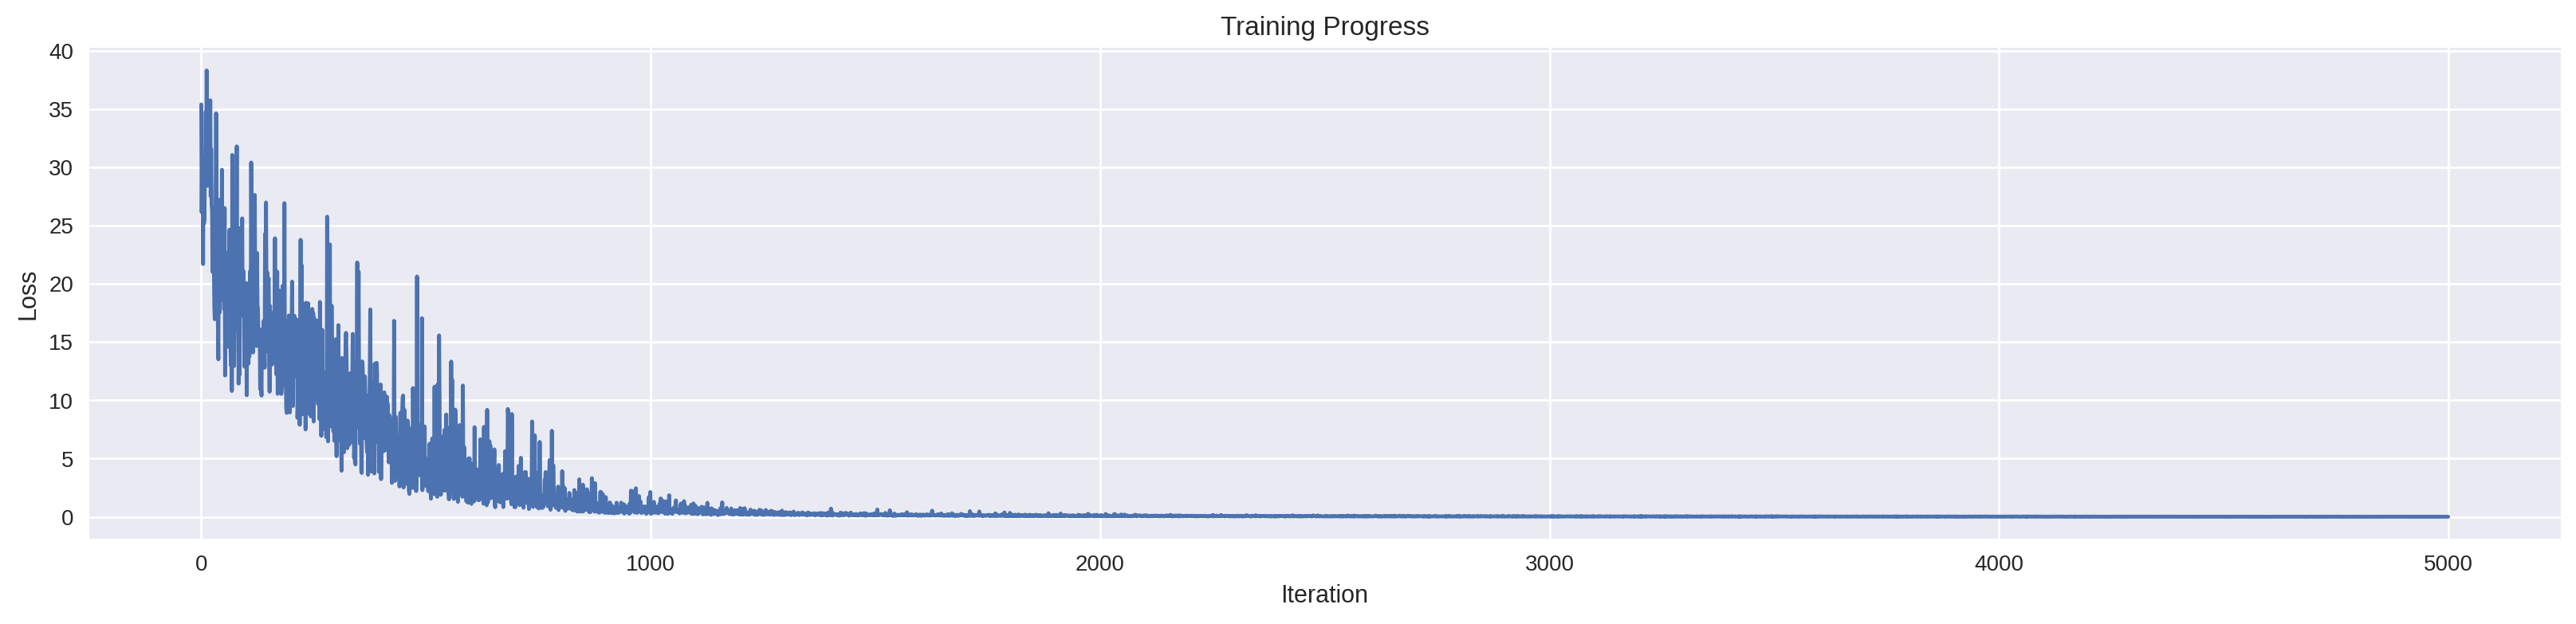

In [17]:
plt.figure(figsize=(20, 4))
plt.plot(loss)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Progress')
plt.show()

### __TEST__

In [18]:
test_sentences = [
    "The water level was low",
    "The crow thought for a moment",
]
for sent in test_sentences:
    response, _, _ = predict(sent)
    print(f"Input:  {sent}")
    print(f"Output: {' '.join(response)}")
    print("-" * 30)

Input:  The water level was low
Output: the water was at the bottom .
------------------------------
Input:  The crow thought for a moment
Output: he found a tall jar .
------------------------------


### __PLOT ALIGNMENT__

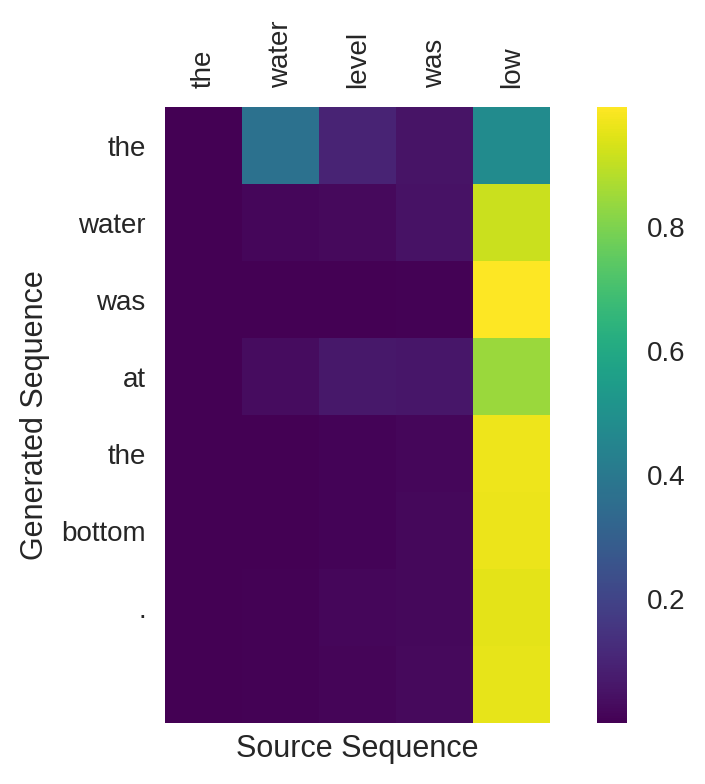

In [21]:
gen_words, attn_matrix, src_words = predict("The water level was low")
plot_attention(src_words, gen_words, attn_matrix)

## **SUMMARY**

This implementation demonstrates **Bahdanau Attention**, the first successful attention mechanism for neural machine translation. The key insight is allowing the decoder to dynamically focus on different parts of the source sentence at each generation step, eliminating the fixed bottleneck of standard encoder-decoder models.

### **Key Achievements in This Notebook:**
1. **Additive Attention**: Implemented the original Bahdanau scoring function
2. **Complete BPTT**: Correctly backpropagate through attention, GRUs, and bridge
3. **Attention Visualization**: Plotted alignment matrices showing which source words influence each generated word

### **Key Points:**
- **Attention solves the bottleneck problem**: Performance doesn't degrade on longer sentences
- **Dynamic context is powerful**: The model learns meaningful alignments without explicit supervision
- **Gradient flow matters**: Proper clipping and initialization are critical for attention stability
- **Attention is interpretable**: We can visualize exactly what the model is "looking at"

### **Limitations of This Approach:**
- **Computational cost**: Attention requires $O(T_{enc} \times T_{dec})$ operations
- **Recurrence**: Still processes sequentially, limiting parallelization
- **Fixed direction**: Encoder must process left-to-right before decoder starts

### **Historical Context:**
This architecture (Bahdanau et al., 2014) was revolutionary, significantly outperforming previous seq2seq models. However, it was later superseded by **Transformers** (Vaswani et al., 2017), which:
- Replace RNNs with **self-attention** entirely
- Process sequences in parallel
- Stack multiple attention heads
- Scale to much larger datasets

### **Further Reading:**

**Attention Papers:**
1. [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473) — Bahdanau et al. (2014)  
   *The paper this notebook implements*

2. [Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/abs/1508.04025) — Luong et al. (2015)  
   *Alternative attention mechanisms (multiplicative, global vs. local)*

**Foundation Papers:**

3. [Learning Phrase Representations using RNN Encoder–Decoder](https://arxiv.org/abs/1406.1078) — Cho et al. (2014)  
   *Introduced GRU and encoder-decoder architecture*

4. [Sequence to Sequence Learning with Neural Networks](https://arxiv.org/abs/1409.3215) — Sutskever et al. (2014)  
   *LSTM-based seq2seq without attention*

**Modern Architectures:**

5. [Attention Is All You Need](https://arxiv.org/abs/1706.03762) — Vaswani et al. (2017)  
   *Transformers — the architecture that powers GPT, BERT, and modern LLMs*

6. [The Illustrated Transformer](http://jalammar.github.io/illustrated-transformer/) — Jay Alammar  
   *Excellent visual guide to understanding Transformers*
